In [ ]:
#TODO: delete this file

In [58]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams, trigrams
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from gensim.models.keyedvectors import KeyedVectors
from collections import defaultdict
import numpy as np

In [1]:
# Define the paths to your files
english_file_path = "fr-en/europarl-v7.fr-en.en"
french_file_path = "fr-en/europarl-v7.fr-en.fr"


In [2]:
########### TASK 1###############

In [3]:
########LOAD DATA###############

In [7]:
"""Function to read a file and return its content. Saves line by line in a list"""

def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.readlines()  # reads all lines into a list
    return content

# Load the data
english_data = read_file(english_file_path)
french_data = read_file(french_file_path)

# Optionally, print the first few lines to check
print("Sample English data:", english_data[:5])
print("Sample French data:", french_data[:5])

Sample English data: ['Resumption of the session\n', 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.\n', "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.\n", 'You have requested a debate on this subject in the course of the next few days, during this part-session.\n', "In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.\n"]
Sample French data: ['Reprise de la session\n', 'Je déclare reprise la session du Parlement européen qui avait été interrompue le vendredi 17 décembre dernier et je vous renouvelle tous me

In [8]:
""" Function to load data into a pandas DataFrame without treating any character as quotes"""


import pandas as pd
from csv import QUOTE_NONE


def load_data_to_dataframe(file_path):
    # Read the entire file as a single column DataFrame, ignoring any quoting
    return pd.read_csv(file_path, header=None, names=['text'], encoding='utf-8', sep='\t', quoting=QUOTE_NONE, engine='python')

# Load the data
english_data = load_data_to_dataframe(english_file_path)
french_data = load_data_to_dataframe(french_file_path)

# Show the first few entries of the DataFrame
print("English DataFrame sample:")
print(english_data.head())
print("French DataFrame sample:")
print(french_data.head())

English DataFrame sample:
                                                text
0                          Resumption of the session
1  I declare resumed the session of the European ...
2  Although, as you will have seen, the dreaded '...
3  You have requested a debate on this subject in...
4  In the meantime, I should like to observe a mi...
French DataFrame sample:
                                                text
0                              Reprise de la session
1  Je déclare reprise la session du Parlement eur...
2  Comme vous avez pu le constater, le grand "bog...
3  Vous avez souhaité un débat à ce sujet dans le...
4  En attendant, je souhaiterais, comme un certai...


In [9]:
##############DATA ANALYSIS##################

In [10]:
## Take fraction of data due to hardware constraints

english_data = english_data[:100000]
french_data = french_data[:100000]


In [11]:
# Vocabulary size

"""
comment: 
Instead of nltk use also spicy tokenizer:
import spacy

# Load the English tokenizer from spaCy
nlp_en = spacy.load('en_core_web_sm')

# Example text
text_en = "Apple's looking at buying U.K. startup for $1 billion"

# Process the text
doc_en = nlp_en(text_en)

# Extract tokens
tokens_en = [token.text for token in doc_en]

print(tokens_en)
"""


def build_vocabulary(text_data):
    # Tokenize the text
    tokens = [word_tokenize(text.lower()) for text in text_data]
    # Flatten the list of token lists into a single list of tokens
    all_tokens = [token for sublist in tokens for token in sublist]
    # Create a Counter object to count unique tokens
    vocabulary = Counter(all_tokens)
    return vocabulary


data_en = english_data["text"]
data_fr = french_data["text"]

# Build vocabularies
vocab_en = build_vocabulary(data_en)
vocab_fr = build_vocabulary(data_fr)

# Get the size of each vocabulary
vocab_size_en = len(vocab_en)
vocab_size_fr = len(vocab_fr)

print(f"English Vocabulary Size: {vocab_size_en}")
print(f"French Vocabulary Size: {vocab_size_fr}")

English Vocabulary Size: 32097
French Vocabulary Size: 46435


In [15]:
# TODO average lenght difference between sentences in source and target language in words and letters

def get_average_lenght_difference(source,target):
    word_lenght_dif=[]
    letter_lenght_dif= []
    for sen_source, sen_target in zip(source["text"],target["text"]):
        #print(sen_source)
        letter_lenght_dif.append(abs(len(sen_source)- len(sen_target)))
        word_lenght_dif.append(abs(len(sen_source.split())-len(sen_target.split())))
    print(np.mean(letter_lenght_dif))
    print(np.mean(word_lenght_dif))
    #print(len(sen_source.split()))

get_average_lenght_difference(english_data,french_data)

#print(english_data)

104.44385
16.84479


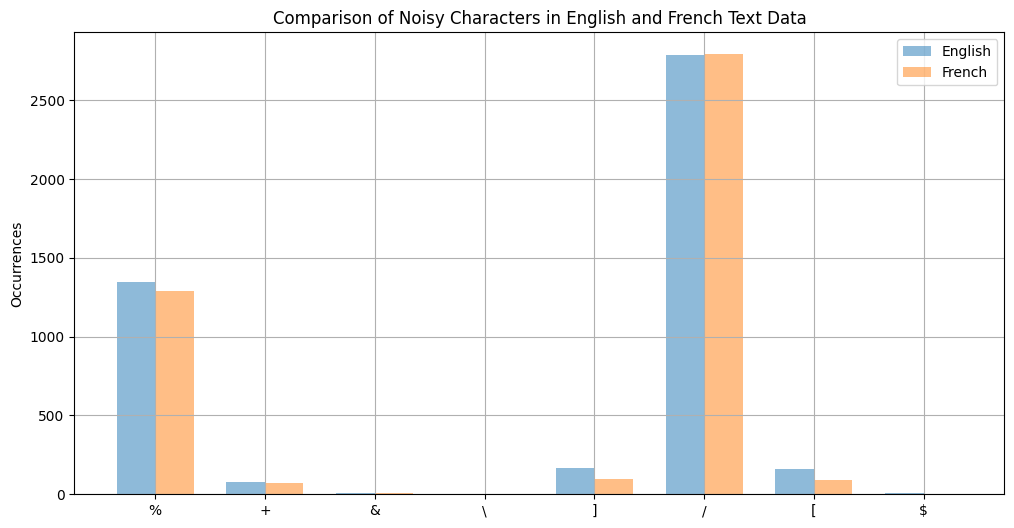

In [16]:


def overlay_noisy_character_counts(data_en, data_fr):
    # Define the characters to remove
    noisy_characters = re.escape('@#$%^&*~<>|\\{}[]+=_/')
    
    # Regex to match any noisy character
    regex_pattern = f'[{noisy_characters}]'
    
    # Function to count characters in a dataframe
    def count_characters(data):
        character_counts = Counter()
        for text in data['text']:
            found_chars = re.findall(regex_pattern, text)
            character_counts.update(found_chars)
        return character_counts

    # Count characters for both datasets
    en_counts = count_characters(data_en)
    fr_counts = count_characters(data_fr)

    # Plotting the occurrences for both English and French data in one overlaid histogram
    plt.figure(figsize=(12, 6))
    labels, en_values = zip(*en_counts.items())  # Unpack keys and values for English
    _, fr_values = zip(*fr_counts.items())      # Unpack values for French
    
    # Ensure both languages have entries for each label
    labels = list(set(labels + tuple(fr_counts.keys())))
    en_values = [en_counts.get(label, 0) for label in labels]
    fr_values = [fr_counts.get(label, 0) for label in labels]

    # Plot
    indices = np.arange(len(labels))  # the x locations for the groups
    width = 0.35                     # the width of the bars
    
    plt.bar(indices - width/2, en_values, width, label='English', alpha=0.5)
    plt.bar(indices + width/2, fr_values, width, label='French', alpha=0.5)

    plt.ylabel('Occurrences')
    plt.title('Comparison of Noisy Characters in English and French Text Data')
    plt.xticks(indices, labels)
    plt.legend()
    plt.grid(True)

    plt.show()

    return en_counts, fr_counts

en_noisy_character_counts, fr_noisy_character_counts = overlay_noisy_character_counts(english_data, french_data)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/niclasstoffregen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


English average word count: 28.07578
French average word count: 29.68897
English average sentence length in letters: 150.65034
French average sentence length in letters: 166.21101


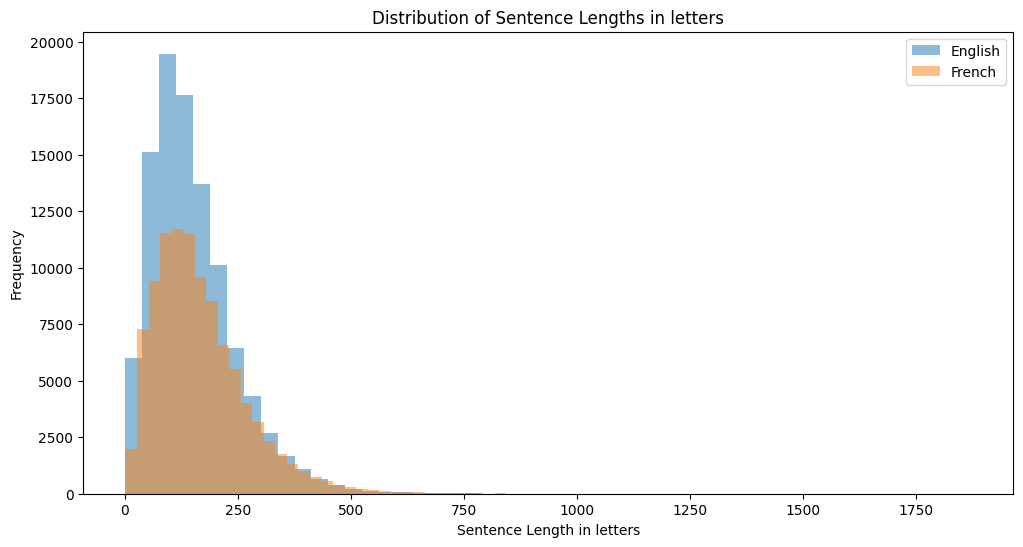

Most common words in English:
[('the', 194588), (',', 135412), ('.', 98053), ('of', 92322), ('to', 87243), ('and', 70213), ('in', 60717), ('is', 43861), ('a', 43345), ('that', 42997)]
Most common words in French:
[(',', 149532), ('de', 145160), ('.', 97245), ('la', 94726), ('et', 63824), ('le', 63380), ('à', 55690), ('les', 54687), ('des', 53036), ('que', 46173)]


In [17]:
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
nltk.download('punkt')

# Adding word count and sentence length columns
english_data['word_count'] = english_data['text'].apply(lambda x: len(word_tokenize(x)))
french_data['word_count'] = french_data['text'].apply(lambda x: len(word_tokenize(x)))

english_data['sentence_length_in_letters'] = english_data['text'].apply(len)
french_data['sentence_length_in_letters'] = french_data['text'].apply(len)

# Basic statistics
print("English average word count:", english_data['word_count'].mean())
print("French average word count:", french_data['word_count'].mean())
print("English average sentence length in letters:", english_data['sentence_length_in_letters'].mean())
print("French average sentence length in letters:", french_data['sentence_length_in_letters'].mean())

# Histogram of sentence lengths
plt.figure(figsize=(12, 6))
plt.hist(english_data['sentence_length_in_letters'], bins=50, alpha=0.5, label='English')
plt.hist(french_data['sentence_length_in_letters'], bins=50, alpha=0.5, label='French')
plt.title('Distribution of Sentence Lengths in letters')
plt.xlabel('Sentence Length in letters')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Most common words
top_n = 10
english_words = Counter(word.lower() for sentence in english_data['text'] for word in word_tokenize(sentence))
french_words = Counter(word.lower() for sentence in french_data['text'] for word in word_tokenize(sentence))

print("Most common words in English:")
print(english_words.most_common(top_n))

print("Most common words in French:")
print(french_words.most_common(top_n))

In [25]:
!python3 -m spacy download en_core_web_sm
!python3 -m spacy download fr_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 5.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [26]:


# Load NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load spaCy models
nlp_en = spacy.load('en_core_web_sm')
nlp_fr = spacy.load('fr_core_news_sm')

# Stopwords setup
stopwords_en = set(stopwords.words('english'))
stopwords_fr = set(stopwords.words('french'))

# Helper function to perform advanced analyses
def analyze_text(data, language):
    
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    data = data.copy()
    # Tokenization and removing punctuation
    data['tokens'] = data['text'].apply(lambda x: [token.text.lower() for token in nlp_en(x) if token.is_alpha])
    data['num_tokens'] = data['tokens'].apply(len)

    # Stopword analysis
    data['stopword_count'] = data['tokens'].apply(lambda x: sum(token in (stopwords_en if language == 'English' else stopwords_fr) for token in x))
    data['stopword_ratio'] = data['stopword_count'] / data['num_tokens']

    # Lexical diversity
    data['lexical_diversity'] = data['tokens'].apply(lambda x: len(set(x)) / len(x) if x else 0)

    # N-Gram analysis
    data['bigrams'] = data['tokens'].apply(lambda x: list(bigrams(x)))
    data['trigrams'] = data['tokens'].apply(lambda x: list(trigrams(x)))

    # POS tagging
    data['pos_tags'] = data['text'].apply(lambda x: [token.pos_ for token in nlp_en(x) if token.is_alpha])

    # Sentence complexity (count of clauses per sentence)
    data['sentence_complexity'] = data['text'].apply(lambda x: sum(1 for token in nlp_en(x) if token.dep_ == 'conj'))

    return data

english_data = analyze_text(english_data, 'English')
french_data = analyze_text(french_data, 'French')

# Example output of analysis
print("English sample analysis:")
print(english_data[['lexical_diversity', 'stopword_ratio', 'sentence_complexity']].head())
print("French sample analysis:")
print(french_data[['lexical_diversity', 'stopword_ratio', 'sentence_complexity']].head())

# Visualization of sentence complexity
plt.figure(figsize=(10, 6))
plt.hist(english_data['sentence_complexity'], bins=30, alpha=0.5, label='English', color='blue')
plt.hist(french_data['sentence_complexity'], bins=30, alpha=0.5, label='French', color='red')
plt.title('Distribution of Sentence Complexity')
plt.xlabel('Number of Clauses per Sentence')
plt.ylabel('Frequency')
plt.legend()
plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/niclasstoffregen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/niclasstoffregen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyboardInterrupt: 

In [27]:
########### TASK 2###############

In [28]:
##################DATA PREPROCESSING#################################

In [29]:
def preprocess_data(data_en, data_fr):
    # Lowercase the text
    """
    Normalizing case helps reduce the complexity of the language model by treating words like “The” and “the” as the same word, which can be particularly helpful in languages like English where capitalization is more stylistic than semantic.
    """
    data_en['text'] = data_en['text'].str.lower()
    data_fr['text'] = data_fr['text'].str.lower()

    # Remove XML tags
    """
    Lines containing XML-tags are likely not actual conversational or formal text but rather formatting or metadata which is irrelevant for translation purposes
    """
    data_en['text'] = data_en['text'].apply(lambda x: '' if x.strip().startswith('<') else x)
    data_fr['text'] = data_fr['text'].apply(lambda x: '' if x.strip().startswith('<') else x)

    # Strip empty lines and remove their correspondences
    """
     Empty lines or lines that do not contain any meaningful content should be removed because they do not provide valuable information for training the model. It is also important to remove the corresponding line in the other language to maintain alignment.
    """
    mask = (data_en['text'].str.strip().astype(bool) & data_fr['text'].str.strip().astype(bool))
    data_en = data_en[mask]
    data_fr = data_fr[mask]

    return data_en, data_fr



"""
Steps Not Chosen and Why:

- Removing Numbers or Special Characters: Not chosen because numbers and certain punctuation can carry semantic weight in sentences, which can be important for translations, such as dates, quantities, or formatted text.
- Stemming/Lemmatization: Not typically used in machine translation preprocessing because retaining the full form of words is important for accurate translation, especially between languages with different linguistic structures.
- Removing Stopwords: Not recommended for translation tasks because stopwords (common words like “and”, “the”, etc.) are crucial for maintaining the grammatical structure of the sentence in both source and target languages.
"""


preprocessed_en, preprocessed_fr  = preprocess_data(english_data,french_data)


In [30]:
import re
"""
Remove all characters that are defined as noise from both translations
"""
def remove_noisy_characters(data):
    # Define the characters to remove
    noisy_characters = re.escape('@#$%^&*~<>|\\{}[]+=_/')
    
    # Regex to match any noisy character
    regex_pattern = f'[{noisy_characters}]'
    
    # Remove noisy characters using regex substitution
    data['text'] = data['text'].apply(lambda x: re.sub(regex_pattern, '', x))
    
    return data


preprocessed_en = remove_noisy_characters(english_data)
preprocessed_fr = remove_noisy_characters(french_data)


In [31]:
import pandas as pd
import re
"""
remove special characterers only if a special character appears in one translation but not in the other and vice versa
"""

def synchronize_special_characters(data_en, data_fr):
    counter = 0
    # Define the characters to synchronize
    special_characters = re.escape('@#$%^&*~<>|\\{}[]+=_/')
    
    # Regex to match any special character
    regex_pattern = f'[{special_characters}]'

    # Process each sentence pair
    for idx in range(len(data_en)):
        if idx >= len(data_fr):  # Ensure index is within the bounds for both dataframes
            break
        
        # Extract texts from both dataframes
        text_en = data_en.loc[idx, 'text']
        text_fr = data_fr.loc[idx, 'text']

        # Find special characters in both texts
        found_chars_en = set(re.findall(regex_pattern, text_en))
        found_chars_fr = set(re.findall(regex_pattern, text_fr))

        # Determine characters to remove (those not in both)
        chars_to_remove = found_chars_en.symmetric_difference(found_chars_fr)

        # Remove the special characters that do not appear in both translations
        if chars_to_remove:
            counter += 1
            remove_regex = '[' + re.escape(''.join(chars_to_remove)) + ']'
            data_en.loc[idx, 'text'] = re.sub(remove_regex, '', text_en)
            data_fr.loc[idx, 'text'] = re.sub(remove_regex, '', text_fr)
    print(counter)
    return data_en, data_fr

data_en_sync, data_fr_sync = synchronize_special_characters(data_en, data_fr)

IndexingError: Too many indexers

In [32]:
"""
Futher Preprocessign steps:

1. Tokenization

	•	Why: Tokenization involves splitting text into words, phrases, or other meaningful elements called tokens. Proper tokenization is crucial as it forms the basis of how input data is fed into the model.
	•	How: Use libraries like NLTK, spaCy, or specialized tokenizer libraries like SentencePiece, which are especially useful for languages without clear word boundaries.

2. Normalization

	•	Why: This step involves standardizing text by correcting typos, expanding contractions (e.g., converting “can’t” to “cannot”), and converting numerals into words. Normalization helps reduce the many variations of the same word, which can dilute the model’s ability to learn.
	•	How: Apply custom rules or use language-specific libraries that handle linguistic variations.

3. Removing/Replacing Non-Text Elements

	•	Why: Non-text elements like numbers, URLs, or user mentions (e.g., Twitter handles) may not be relevant and could distract the model from learning linguistic patterns.
	•	How: Detect and replace these elements with generic placeholders like <number>, <url>, or <user>.

4. Punctuation Cleaning

	•	Why: While removing all punctuation can be harmful, normalizing punctuation and ensuring consistent use can be very beneficial. For example, converting fancy quotation marks to standard ones (’ or “) ensures consistency.
	•	How: Replace or remove specific punctuation characters that are not beneficial for the training process.

5. Handling Rare Words and Out-of-Vocabulary (OOV) Issues

	•	Why: Rare words can lead to problems during training, as the model might overfit to these instances. Handling them can improve model robustness.
	•	How: Replace rare words with a <unk> token or use subword tokenization techniques (like BPE or SentencePiece) to decompose rare words into more common subwords.

6. Stop Words Removal (Conditional)

	•	Why: For some NLP tasks like topic modeling or keyword extraction, removing common words (stop words) that carry minimal meaningful information can focus the model on more important terms.
	•	How: Use libraries like NLTK or spaCy to remove stop words, but this is generally not recommended for machine translation unless specifically required for a styled translation.

7. Part-of-Speech Tagging and Syntactic Parsing (Advanced)

	•	Why: This can help in understanding sentence structure and can be used to improve alignment in parallel corpora.
	•	How: Use language models from libraries like spaCy to annotate words with their parts of speech or to parse sentence structure.



"""

'\nFuther Preprocessign steps:\n\n1. Tokenization\n\n\t•\tWhy: Tokenization involves splitting text into words, phrases, or other meaningful elements called tokens. Proper tokenization is crucial as it forms the basis of how input data is fed into the model.\n\t•\tHow: Use libraries like NLTK, spaCy, or specialized tokenizer libraries like SentencePiece, which are especially useful for languages without clear word boundaries.\n\n2. Normalization\n\n\t•\tWhy: This step involves standardizing text by correcting typos, expanding contractions (e.g., converting “can’t” to “cannot”), and converting numerals into words. Normalization helps reduce the many variations of the same word, which can dilute the model’s ability to learn.\n\t•\tHow: Apply custom rules or use language-specific libraries that handle linguistic variations.\n\n3. Removing/Replacing Non-Text Elements\n\n\t•\tWhy: Non-text elements like numbers, URLs, or user mentions (e.g., Twitter handles) may not be relevant and could di

In [33]:
#######TRAINING#############

In [34]:
#Split data into Train, Val, Test


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_en, data_fr, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [35]:
"""
Model Architecture:
Encoder: An RNN (LSTM or GRU) that processes the input sentence and encodes it into a context vector.
Decoder: Another RNN that takes the context vector and generates the output sentence in the target language.
"""
import torch
import torch.nn as nn
import torch.optim as optim

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))
    

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = nn.functional.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))
    


In [36]:
# init decoder and encoder and loss function 

input_size = vocab_size_en   # size of the English vocabulary was calculated in task 1
output_size = vocab_size_fr  # size of the French vocabulary was calculated in task 1
hidden_size = 256            # typically a power of 2 like 256 or 512

encoder = EncoderRNN(input_size, hidden_size)
decoder = DecoderRNN(hidden_size, output_size)



criterion = nn.NLLLoss()
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.01)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.01)

In [37]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    # Encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

    # Decoder initialization without an SOS token
    # The first input to the decoder could be an assumed blank token, often just zeros
    decoder_input = torch.zeros((1, 1), dtype=torch.long)  # Assuming your vocab is zero-indexed
    decoder_hidden = encoder_hidden  # Use the last hidden state from the encoder to start the decoder

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # Use model's own prediction as next input

        loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
        # Check if decoder has generated the end of sequence, often by target length or a special condition
        if di == target_length - 1:  # Simple condition assuming reaching the end of target tensor
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [38]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    print_loss_total = 0  # Reset every print_every

    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'Iteration: {iter} Average Loss: {print_loss_avg:.4f}')

In [39]:
#Create Embeddings manually 

import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
#nltk.download('punkt')


data = {
    'X_train': X_train.tolist(),
    'y_train': y_train.tolist()
}

df = pd.DataFrame(data)

# Tokenization function
def tokenize(sentences):
    return [word_tokenize(sentence.lower()) for sentence in sentences]

# Building vocabulary
def build_vocab(tokenized_texts):
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    for tokens in tokenized_texts:
        for token in tokens:
            vocab[token]
    return vocab

# Convert texts to numerical indices
def numericalize(texts, vocab):
    return [[vocab[token] for token in tokens] for tokens in tokenize(texts)]

# Tokenize and build vocabularies
tokenized_x = tokenize(df['X_train'])
tokenized_y = tokenize(df['y_train'])

#{token(in this case a word):number} ex. 'watts': 4239
vocab_x = build_vocab(tokenized_x)
vocab_y = build_vocab(tokenized_y)

# Numericalize the data
numericalized_x = numericalize(df['X_train'], vocab_x)
numericalized_y = numericalize(df['y_train'], vocab_y)

# Convert lists to PyTorch tensors and pad sequences
input_tensor = pad_sequence([torch.tensor(seq) for seq in numericalized_x], batch_first=True, padding_value=0)
target_tensor = pad_sequence([torch.tensor(seq) for seq in numericalized_y], batch_first=True, padding_value=0)

print(input_tensor)
print(target_tensor)

tensor([[   0,    1,    2,  ...,    0,    0,    0],
        [  18,   19,   20,  ...,    0,    0,    0],
        [  28,   14,   29,  ...,    0,    0,    0],
        ...,
        [  29,    6, 1091,  ...,    0,    0,    0],
        [ 664,   14,    6,  ...,    0,    0,    0],
        [ 460,   18,  183,  ...,    0,    0,    0]])
tensor([[   0,    1,    2,  ...,    0,    0,    0],
        [  29,   30,    2,  ...,    0,    0,    0],
        [  24,   46,   47,  ...,    0,    0,    0],
        ...,
        [ 324, 4860,  641,  ...,    0,    0,    0],
        [ 120,  641, 1291,  ...,    0,    0,    0],
        [ 264,    2,   29,  ...,    0,    0,    0]])


In [40]:
#TODO takes to much time..

import random

# Number of iterations (epochs)
num_iterations = 10000
print_every = 1000

for iter in range(1, num_iterations + 1):
    # Randomly selecting an example each time (for simplicity in this example)
    # Ideally, use a more systematic way to create batches and cycle through data
    input_example = random.choice(input_tensor)
    target_example = random.choice(target_tensor)
    loss = train(input_example, target_example, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, 1000)
    if iter % print_every == 0:
        print(f'Iter: {iter}, Loss: {loss:.4f}')

KeyboardInterrupt: 

In [41]:
####### TODO TRAIN MODEL WITH SOS AND EOS TOKEN #########

In [42]:
#TODO add SOS and EOS tokens 

SOS_token = 0  # Assuming 0 is the index for SOS token in your vocabulary
EOS_token = 1  # Assuming 1 is the index for EOS token in your vocabulary

def add_special_tokens(sentences, sos_token, eos_token=None):
    # Add an SOS token at the beginning of each sentence.
    # Optionally, add an EOS token at the end.
    updated_sentences = []
    for sentence in sentences:
        modified_sentence = [sos_token] + sentence
        if eos_token is not None:
            modified_sentence += [eos_token]
        updated_sentences.append(modified_sentence)
    return updated_sentences


In [43]:
########################## USE DIFFERENT EMBEDDING MODELS #################



In [44]:
"""Here’s a breakdown of how these steps align with the use of pre-trained embeddings:

1. Tokenization

Tokenization remains a necessary first step because it transforms raw text into lists of words or subwords. This process is independent of whether you use pre-trained embeddings.

2. Build Vocabulary

When using pre-trained embeddings, you build a vocabulary that aligns closely with the vocabulary used by the embeddings. Often, this means adapting your dataset’s vocabulary to match the pre-trained set:

	•	Include only words found in the pre-trained embeddings: Words not present in the embeddings can be handled by a special token like <unk> (unknown).
	•	Reuse pre-trained special tokens if available: Some embeddings include tokens for unknown words, start of sentences, or padding, which you should utilize if consistent with your model architecture.

3. Numericalization

This step converts the tokenized sentences into sequences of indices based on the vocabulary. For models using pre-trained embeddings, these indices correspond to the rows in the embedding matrix where each word’s vector is stored.

4. Padding

To handle variable-length sequences in batch processing efficiently, padding is necessary. This step standardizes the length of all sequences in a batch by appending a special padding token (often mapped to a zero vector in the embedding matrix).

5. Convert to Tensors

Finally, the lists of indices are converted to PyTorch tensors, which can be efficiently processed by your model. These tensors are what you will feed into your neural network.

Incorporating Pre-trained Embeddings

After preparing your tensors:

	•	Load Embedding Matrix: Load your pre-trained embedding matrix, ensuring it corresponds to your vocabulary.
	•	Set Model’s Embedding Layer: Initialize the embedding layer of your model with the pre-trained embeddings. You can choose to freeze these weights (to prevent further training) or allow them to fine-tune during training based on your specific needs."""

'Here’s a breakdown of how these steps align with the use of pre-trained embeddings:\n\n1. Tokenization\n\nTokenization remains a necessary first step because it transforms raw text into lists of words or subwords. This process is independent of whether you use pre-trained embeddings.\n\n2. Build Vocabulary\n\nWhen using pre-trained embeddings, you build a vocabulary that aligns closely with the vocabulary used by the embeddings. Often, this means adapting your dataset’s vocabulary to match the pre-trained set:\n\n\t•\tInclude only words found in the pre-trained embeddings: Words not present in the embeddings can be handled by a special token like <unk> (unknown).\n\t•\tReuse pre-trained special tokens if available: Some embeddings include tokens for unknown words, start of sentences, or padding, which you should utilize if consistent with your model architecture.\n\n3. Numericalization\n\nThis step converts the tokenized sentences into sequences of indices based on the vocabulary. For

In [48]:
# Example GloVe embedding file path and embedding dimension

import numpy as np
import torch
from typing import Dict

def load_glove_embeddings(path: str, word2idx: Dict[str, int], embedding_dim: int) -> torch.Tensor:
    """
    Load GloVe embeddings from a specified file and align them with the given word index dictionary.

    Parameters:
    - path (str): The file path to the GloVe embeddings file.
    - word2idx (Dict[str, int]): A dictionary mapping words to their corresponding indices. This dictionary defines
      the position each word’s vector should occupy in the resulting embedding matrix.
    - embedding_dim (int): The dimensionality of the GloVe vectors (e.g., 50, 100, 200, 300).

    Returns:
    - torch.Tensor: A tensor of shape (len(word2idx), embedding_dim) containing the GloVe vectors aligned according to word2idx.
    """
    with open(path, 'r', encoding='utf-8') as f:
        # Initialize the embedding matrix with zeros
        embeddings = np.zeros((len(word2idx), embedding_dim))
        
        # Process each line in the GloVe file
        for line in f:
            values = line.split()
            word = values[0]
            
            # If the word is in the provided dictionary, update the corresponding row in embeddings
            if word in word2idx:
                # Convert embedding values from strings to float32
                vector = np.asarray(values[1:], dtype='float32')
                # Place the vector in the correct index as per word2idx
                embeddings[word2idx[word]] = vector
    
    # Convert the numpy array to a PyTorch tensor
    return torch.from_numpy(embeddings)


def load_embeddings_and_create_index(path):
    word_to_idx = {}
    idx = 0
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            word_to_idx[word] = idx
            idx += 1
    return word_to_idx

# Load the word to index mappings for both languages
word_to_idx_en = load_embeddings_and_create_index('glove.6B/glove.6B.100d.txt')
word_to_idx_fr = load_embeddings_and_create_index('glove.6B/glove.6B.100d.txt')


In [49]:


# Load data
data_en = pd.DataFrame({'sentence': X_train.tolist()}) 
data_fr = pd.DataFrame({'sentence': y_train.tolist()})  

# Tokenization
def tokenize(text):
    return text.lower().split()

# Vocabulary mapping
class Vocabulary:
    def __init__(self, token_to_idx=None):
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx
        self.idx_to_token = {idx: token for token, idx in self.token_to_idx.items()}
    
    def add_word(self, word):
        if word not in self.token_to_idx:
            idx = len(self.token_to_idx)
            self.token_to_idx[word] = idx
            self.idx_to_token[idx] = word
    
    def __call__(self, word):
        return self.token_to_idx.get(word, self.token_to_idx['<unk>'])
    
    def __len__(self):
        return len(self.token_to_idx)

# Build vocabularies for both languages
def build_vocab(sentences, existing_embeddings_word2idx):
    vocab = Vocabulary()
    vocab.add_word('<pad>')  # Assuming you handle padding explicitly
    vocab.add_word('<unk>')  # Handle unknown words

    for sentence in sentences:
        tokens = tokenize(sentence)
        for token in tokens:
            if token in existing_embeddings_word2idx:
                vocab.add_word(token)
    return vocab

vocab_en = build_vocab(data_en['sentence'], word_to_idx_en)
vocab_fr = build_vocab(data_fr['sentence'], word_to_idx_fr)

# Dataset preparation
class TranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences, source_vocab, target_vocab):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
    
    def __len__(self):
        return len(self.source_sentences)
    
    def __getitem__(self, index):
        source_sentence = [self.source_vocab(token) if token in self.source_vocab.token_to_idx else self.source_vocab('<unk>') for token in tokenize(self.source_sentences.iloc[index])]
        target_sentence = [self.target_vocab(token) if token in self.target_vocab.token_to_idx else self.target_vocab('<unk>') for token in tokenize(self.target_sentences.iloc[index])]
        return torch.tensor(source_sentence, dtype=torch.long), torch.tensor(target_sentence, dtype=torch.long)

# Collate function for padding
def collate_fn(batch):
    source_batch, target_batch = zip(*batch)
    source_batch_padded = pad_sequence(source_batch, padding_value=vocab_en('<pad>'), batch_first=True)
    target_batch_padded = pad_sequence(target_batch, padding_value=vocab_fr('<pad>'), batch_first=True)
    return source_batch_padded, target_batch_padded


In [54]:
import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self, hidden_size, pretrained_embeddings):
        
        """
        Initialize the Encoder with pre-trained embeddings and a GRU layer.

        Parameters:
            hidden_size (int): The number of features in the hidden state of the GRU.
            pretrained_embeddings (torch.Tensor): A tensor containing the pre-trained word embeddings.
        """
        super(Encoder, self).__init__()
        # Ensure that the pretrained embeddings are of type float32
        if pretrained_embeddings.dtype != torch.float32:
            pretrained_embeddings = pretrained_embeddings.to(dtype=torch.float32)
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        embed_size = pretrained_embeddings.shape[1]  # Embedding size is the second dimension of the embeddings tensor
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True).float()  # Ensure GRU is initialized as float32

    def forward(self, x):
        """
        Forward pass of the encoder which processes the input sequence.
    
        Parameters:
            x (torch.Tensor): The input sequence tensor, which should be indexed by batch.
    
        Returns:
            hidden (torch.Tensor): The hidden state of the GRU, representing the encoded information of the input.
        """
        embedded = self.embedding(x).float()  # Ensure embedding outputs float32
        _, hidden = self.rnn(embedded)
        return hidden

class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, output_size, pretrained_embeddings):
        """
        Initialize the Decoder with pre-trained embeddings, a GRU layer, and a linear output layer.

        Parameters:
            embed_size (int): The size of each embedding vector.
            hidden_size (int): The number of features in the hidden state of the GRU.
            output_size (int): The size of the output vocabulary.
            pretrained_embeddings (torch.Tensor): A tensor containing the pre-trained word embeddings.

        """
        
        super(Decoder, self).__init__()
        # Ensure that the pretrained embeddings are of type float32
        if pretrained_embeddings.dtype != torch.float32:
            pretrained_embeddings = pretrained_embeddings.to(dtype=torch.float32)
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True).float()  # Ensure GRU is initialized as float32
        self.fc = nn.Linear(hidden_size, output_size).float()  # Ensure Linear is initialized as float32

    def forward(self, x, hidden):
        """
        Forward pass of the decoder that processes one timestep of the sequence.

        Parameters:
            x (torch.Tensor): The input tensor for the current timestep.
            hidden (torch.Tensor): The hidden state from the last timestep.

        Returns:
            predicted (torch.Tensor): The output logits for the next word in the sequence.
            hidden (torch.Tensor): The updated hidden state.
        """
        embedded = self.embedding(x).float()  # Ensure embedding outputs float32
        output, hidden = self.rnn(embedded, hidden)
        predicted = self.fc(output)
        return predicted, hidden
    
class Seq2Seq(nn.Module):

        
    def __init__(self, encoder, decoder):
        """
        Initialize the sequence-to-sequence model which contains an encoder and a decoder.
    
        Parameters:
            encoder (Encoder): The encoder part of the Seq2Seq model.
            decoder (Decoder): The decoder part of the Seq2Seq model.
        """
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, src, trg):
        """
        Forward pass of the Seq2Seq model which processes the entire input and target sequence.

        Parameters:
            src (torch.Tensor): The input sequence tensor.
            trg (torch.Tensor): The target sequence tensor used during training.

        Returns:
            outputs (torch.Tensor): The output from the decoder for each step in the sequence.
        """
        hidden = self.encoder(src)
        outputs, _ = self.decoder(trg, hidden)
        return outputs




In [59]:

def train(model, loader, optimizer, criterion, epochs=10, device="cpu"):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        total_loss = 0
        for src, trg in loader:
            # Move tensors to the correct device and ensure they are long type for indexing operations
            src = src.to(device).long()  # Correct type for embedding layer
            trg = trg.to(device).long()  # Correct type for embedding layer
            

            optimizer.zero_grad()

            # Forward pass: The decoder's input is all except the last word
            output = model(src, trg[:, :-1])  
            
            # Since output will be in float (from linear layers, and GRU output), ensure it's float32 if not already
            output = output.float()

            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)  # Target doesn't include the first <sos> token

            loss = criterion(output, trg)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        average_loss = total_loss / len(loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}')
        
        


In [60]:
# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Init and run

# Load embeddings
glove_embeddings_en = load_glove_embeddings('glove.6B/glove.6B.100d.txt', vocab_x, embedding_dim)
glove_embeddings_fr = load_glove_embeddings('glove.6B/glove.6B.100d.txt', vocab_x, embedding_dim)

# Model instantiation
encoder = Encoder(hidden_size=hidden_size, pretrained_embeddings=glove_embeddings_en)
decoder = Decoder(embed_size=embedding_dim, hidden_size=hidden_size, output_size=len(vocab_fr), pretrained_embeddings=glove_embeddings_fr)
model = Seq2Seq(encoder, decoder)
# Move the model to the configured device
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss(ignore_index=vocab_fr.token_to_idx['<pad>']).to(device)  # Move the loss function to the device


dataset = TranslationDataset(data_en['sentence'], data_fr['sentence'], vocab_en, vocab_fr)
loader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn)

train(model, loader, optimizer, criterion, epochs=10, device=device)

Using device: cpu


NameError: name 'embedding_dim' is not defined